In [0]:
#import required packages
import tensorflow as tf #library needed to implement LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #library for preprocessing data
from sklearn.model_selection import train_test_split #library for splitting data into train and test
import io #library to read uploaded data file

In [0]:
#code for uploading csv file
from google.colab import files
uploadedFile = files.upload()

Saving trimmedprices.csv to trimmedprices.csv


In [0]:
#converting file to dataset
dataset = pd.read_csv(io.StringIO(uploadedFile['trimmedprices.csv'].decode('utf-8')))
#Check null or missing values in dataset
print(dataset.isna().sum())

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


In [0]:
#Close is selected as forecasting feature in the dataset as we are implementing univariate LSTM
closeValues=dataset['close'].values

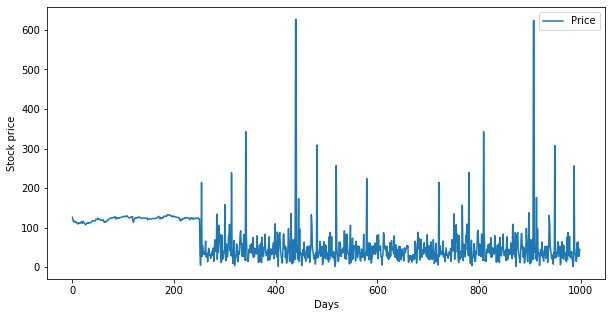

In [0]:
#Splitting data into train and test sets and then standardizing the data

scaler = StandardScaler()
data_train, data_test= train_test_split(closeValues, train_size=0.8, test_size=0.2, shuffle=False)
data_train= scaler.fit_transform(data_train.reshape(-1, 1))
data_test=scaler.transform(data_test.reshape(-1, 1))

#Plotting dataset for verifying data distribution
plt.figure(figsize=(10,5))
plt.xlabel('Days')
plt.ylabel('Stock price')
plt.plot(closeValues, label='Price')
plt.legend()
plt.show()

In [0]:
#Constant variables for lstm.
SampleSize = 7   #sample size is the number of samples the neural net uses to predict the next value
windowSize = 7
hiddenLayers = 256
lr = 0.001
epochs = 100

In [0]:
#Convert data into samples of size equal to the window size
def windowData(d):
    x = []
    y = []
    i = 0
    for i in range(len(d)):
      limit = i+windowSize
      if(limit < len(d)):
        x.append(d[i:limit])
        y.append(d[limit])
    return x, y

#Get the training and testing data converted into samples of the size equal to the window size
x_train, y_train = windowData(data_train)
x_test, y_test = windowData(data_test)

In [0]:
#Define input and otput placeholders 

input_placeholder = tf.placeholder(tf.float32, [SampleSize, windowSize, 1])
target_placeholder = tf.placeholder(tf.float32, [SampleSize, 1])

#Method for intializing variables(weights,hiddenLayerWeights,Bias) for each gate of network
def initialize_weights():
  weight=	tf.Variable(tf.truncated_normal([1, hiddenLayers], stddev=0.1))
  hiddenWeight=tf.Variable(tf.truncated_normal([hiddenLayers, hiddenLayers], stddev=0.1))
  bias= tf.Variable(tf.zeros([hiddenLayers]))
  return weight,hiddenWeight,bias

#Weights for the input gate
inputWeight,inputHiddenWeight,inputBias = initialize_weights()

#weights for the forget gate
forgotWeight,forgotHiddenWeight,forgotBias = initialize_weights()

#weights for the output gate
outputWeight,outputHiddenWeight,outputBias = initialize_weights()

#weights for the memory cell
memoryWeight,memoryHiddenWeight,memoryBias = initialize_weights()

#weights for output layer
outputLayerWeight = tf.Variable(tf.truncated_normal([hiddenLayers, 1], stddev=0.1))
outputLayerBias = tf.Variable(tf.zeros([1]))

def GateManipulation(gateType,input,output,gateWeight,hiddenWeight,bias):
    val = tf.add(tf.matmul(input, gateWeight),tf.matmul(output, hiddenWeight)) + bias
    if gateType != 'MemoryCell':
      return tf.sigmoid(val)
    else:
      return tf.tanh(val)

#function to compute the gate states
def LSTM(input, state, output):
    
    inputGate = GateManipulation('Input',input,output, inputWeight, inputHiddenWeight, inputBias)
    
    forgotGate = GateManipulation('Forget',input, output, forgotWeight, forgotHiddenWeight, forgotBias)
    
    outputGate = GateManipulation('Output',input, output, outputWeight, outputHiddenWeight, outputBias)
    
    memoryCell = GateManipulation('MemoryCell',input, output, memoryWeight, memoryHiddenWeight, memoryBias)
    
    state = state * forgotGate + inputGate * memoryCell
    
    output = outputGate * tf.tanh(state)
    return state, output
  
  
#Looping network over samples of data. Each sample contains window data.
output = []
for i in range(SampleSize): 
    
    batchState = np.zeros([1, hiddenLayers], dtype=np.float32) 
    batchOutput = np.zeros([1, hiddenLayers], dtype=np.float32)
    
    for j in range(windowSize):
        batchState, batchOutput = LSTM(tf.reshape(input_placeholder[i][j], (-1, 1)), batchState, batchOutput)
        
    #last output of LSTM is  used to get a prediction
    output.append(tf.add(tf.matmul(batchOutput, outputLayerWeight),outputLayerBias))

In [0]:
#Defining MSE cost function for optimization
loss = []

for i in range(len(output)):
    loss.append(tf.losses.mean_squared_error(tf.reshape(target_placeholder[i], (-1, 1)), output[i]))
    
meanLoss = tf.reduce_mean(loss)

#Adam Optimizer 
gradients = tf.gradients(meanLoss, tf.trainable_variables())
optimizer = tf.train.AdamOptimizer(lr)
trainOptimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#Training the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    score = []
    j = 0
    lossPerEpoch = []
    while(j + SampleSize) <= len(x_train):
        x_batch = x_train[j:j+SampleSize]
        y_batch = y_train[j:j+SampleSize]
        outputPerBatch, lossPerBatch, rest = session.run([output, meanLoss, trainOptimizer], feed_dict={input_placeholder:x_batch, target_placeholder:y_batch})
        lossPerEpoch.append(lossPerBatch)
        score.append(outputPerBatch)
        j += SampleSize
    print('Epoch '+str(i+1)+' Loss: '+str(np.mean(lossPerEpoch)))

Epoch 1 Loss: 0.6377423
Epoch 2 Loss: 0.6349931
Epoch 3 Loss: 0.59749043
Epoch 4 Loss: 0.5814529
Epoch 5 Loss: 0.5676835
Epoch 6 Loss: 0.5557532
Epoch 7 Loss: 0.5362692
Epoch 8 Loss: 0.52496356
Epoch 9 Loss: 0.52848375
Epoch 10 Loss: 0.5071818


In [0]:
#Predicting over train dataset
train_predicted =[]
for i in range(len(score)):
    for j in range(len(score[i])):
        train_predicted.append(score[i][j][0])

#Train MSE
count=0
while count < len(train_predicted):
    diff=train_predicted[count]-y_train[count]
    squareDiff=diff*diff
    count+=1
train_mse=squareDiff/len(train_predicted)
print("Training MSE:",train_mse[0])

Training MSE: 0.0008367455905970606


In [0]:
#Predicting over Test dataset
testScore = []
i = 0
while i+SampleSize <= len(x_test): 
    outputPerBatch = session.run([output],feed_dict={input_placeholder:x_test[i:i+SampleSize]})
    i += SampleSize
    testScore.append(outputPerBatch)

In [0]:
 #Test MSE
 test_predicted = []
 for i in range(len(testScore)):
  for j in range(len(testScore[i][0])):
   test_predicted.append(testScore[i][0][j])
count=0
while count < len(test_predicted):
    diff=test_predicted[count]-y_test[count]
    squareDiff=diff*diff
    count+=1
test_mse=squareDiff/len(test_predicted)
print("Test MSE: ",test_mse[0][0])

Test MSE:  0.0005372213507825771


In [0]:
#Get the total predicted data from the train and test predicted data
predicted_data=[]
print(len(train_predicted))
print(len(test_predicted))
for i in range(0,791):
  predicted_data.append(train_predicted[i])
for i in range(791,980):
  predicted_data.append(test_predicted[i-791])

791
189


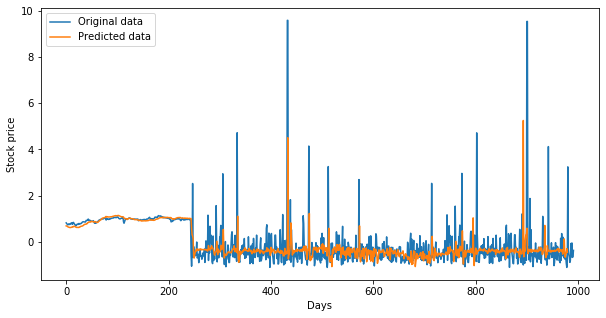

In [0]:
#Plot to see actual and predicted closing values
plt.figure(figsize=(10, 5))
plt.xlabel('Days')
plt.ylabel('Stock price')
#Since the predicted data is scaled, we need to scale the original data as well to see the correct plot
closeValues=scaler.fit_transform(closeValues.reshape(-1,1))
predicted_data_actual=closeValues[7:]
plt.plot(predicted_data_actual, label='Original data')
plt.plot(predicted_data, label='Predicted data')
plt.legend()
plt.show()

In [0]:
#Total MSE
count=0
while count < len(predicted_data):
    diff=predicted_data[count]-predicted_data_actual[count]
    squareDiff=diff*diff
    count+=1
total_mse=squareDiff/len(predicted_data)
print("Total MSE: ",total_mse[0][0])

Total MSE:  0.00016508564596395635
